# Прогнозирование заказов такси
Для компании, работающей в аэропортах, необходимо предсказать количество заказов такси на следующий час, имея в распоряжении исторические данные

In [274]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import lightgbm as lgb

import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

[1. Загрузка данных](#data_download)    
[2. Знакомство в с данными. Предобработка](#data_preprocessing)  
[3. Feature engeneering](#feature_engeneering)    
[4. Выбор модели, обучение, предсказание](#ml_process)  
[5. Выводы](#Conclusion)    


<a id='data_download'></a>
### 1. Загрузка данных

In [275]:
#загрузим данные
try:
    data = pd.read_csv('/Users/ulia/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [276]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [277]:
plotly_df(data, title = "First glance")

In [278]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [279]:
(data.index.min(), data.index.max())

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

В датасете представлены данные с 1 марта по 31 августа 2018 года  
Пропусков нет

<a id='data_preprocessing'></a>
### 2. Знакомство в с данными. Предобработка

In [280]:
# У нас даны данные с интервалом в 10 минут , сгруппируем данные по часу:

data = data.resample('1H').sum()
plotly_df(data, 'Данные после resampling')

После увеличения на графике хорошо видны тренды и сезонность, также выделяются пики в августе  

In [281]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [282]:
#Декомпозируем данные, выделим сезонность
decomposed = seasonal_decompose(data)

In [283]:
seasonal = pd.DataFrame(decomposed.seasonal)
plotly_df(seasonal['2018-08-01':'2018-08-31'], 'Сезонность')

In [284]:
plotly_df(seasonal['2018-08-29':'2018-08-31'], 'Сезонность в рамках дней')

Удалось выделить сезонность - больше всего заказов в полночь - потом локальные пики в 10 и 16 часов, провал - в районе 6 часов утра  


In [285]:
trend = pd.DataFrame(decomposed.trend)
plotly_df(trend, 'Тренд')

Наблюдаем положительный тренд, число заказов постоянно растет с марта до августа  

<a id='feature_engeneering'></a>
### 3. Feature engeneering

In [286]:
def code_mean(data, cat_features, real_feature):
    return dict(data.groupby(cat_features)[real_feature].mean())

In [287]:
def prepare_data(data, lags, test_size=0.1):
    df = pd.DataFrame(data.copy())
    df.columns = ['y']
    
    test_index = int(len(data)*(1-test_size))

    #добавляем лаги
    for lag in lags:
        df['lag_{}'.format(lag)] = df.y.shift(lag)


    #data.index = data.index.to_datetime()
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['is_weekend']= df.weekday.isin([5,6])*1

    df['weekday_average'] = list(map(code_mean(df[:test_index],'weekday','y').get, df.weekday))
    df['hour_average'] = list(map(code_mean(df[:test_index],'hour','y').get, df.hour))
    
    df.drop(['hour','weekday'], axis=1, inplace=True)
    
    # удалим строки с пропусками
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    #разбиваем на тренировочную, тестовую и валидационную выборки:
    features = df.drop('y', axis=1)
    target = df['y']



    features_train_full, features_test, target_train_full, target_test = train_test_split(features, target, test_size=test_size, shuffle=False)
    
    features_train, features_valid, target_train, target_valid = train_test_split(features_train_full, target_train_full, test_size=test_size,shuffle=False)
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [288]:
features_train, features_valid, features_test, target_train, target_valid, target_test = prepare_data(data, [1,2,3,4,5,6,7], 0.1)

In [289]:
(features_train.index.max(), features_valid.index.min())

(3570, 3571)

In [290]:
(features_valid.index.max(), features_test.index.min())

(3967, 3968)

Разбиение на выборки выполнено корректно

In [291]:
features_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,is_weekend,weekday_average,hour_average
0,12.00,6.00,43.00,66.00,71.00,85.00,124.00,0,78.28,27.44
1,15.00,12.00,6.00,43.00,66.00,71.00,85.00,0,78.28,68.23
2,34.00,15.00,12.00,6.00,43.00,66.00,71.00,0,78.28,81.60
3,69.00,34.00,15.00,12.00,6.00,43.00,66.00,0,78.28,86.25
4,64.00,69.00,34.00,15.00,12.00,6.00,43.00,0,78.28,77.10


<a id='ml_process'></a>
### 4. Выбор модели, обучение, предсказание

In [292]:
numeric = list(features_train.columns)

In [293]:
numeric.remove('is_weekend')

In [294]:
numeric

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'weekday_average',
 'hour_average']

In [295]:
# нормализуем данные:
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [296]:
# обучим модель линейной регрессии
reg_model = LinearRegression()
reg_model.fit(features_train, target_train)
predictions_reg = reg_model.predict(features_valid)
MSE_reg = mean_squared_error(predictions_reg, target_valid, squared=False)


In [297]:
print('Значение RMSE на линейной регрессии {:.2f}'.format(MSE_reg))

Значение RMSE на линейной регрессии 35.75


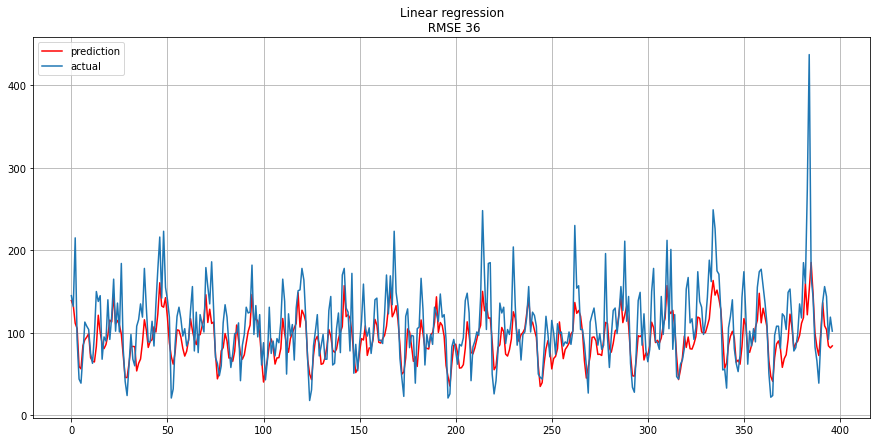

In [298]:
plt.figure(figsize=(15, 7))
plt.plot(predictions_reg, "r", label="prediction")
plt.plot(target_valid.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n RMSE {}".format(round(MSE_reg)))
plt.grid(True)

Хотя RMSE ниже порога в 48 единиц, трудно сказать, что предсказание очень хорошее

In [299]:
RMSE_reg_test = mean_squared_error(reg_model.predict(features_test), target_test, squared=False)

In [300]:
RMSE_reg_test
print('Значение линейной регрессии на тестовой выборке {:.2f}'.format(RMSE_reg_test))

Значение линейной регрессии на тестовой выборке 52.48


In [301]:
#Попробуем разное количество лагов для модели:
def test_reg_model(lags):
    res = {}
    for i in list(range(3, lags+1)):
        features_train, features_valid, features_test, target_train, target_valid, target_test = prepare_data(data, list(range(1,i+1)), 0.1)
        numeric = list(features_train.columns)
        numeric.remove('is_weekend')
        scaler = StandardScaler()
        features_train[numeric] = scaler.fit_transform(features_train[numeric])
        features_valid[numeric] = scaler.transform(features_valid[numeric])
        features_test[numeric] = scaler.transform(features_test[numeric])
        reg_model = LinearRegression()
        reg_model.fit(features_train, target_train)
        predictions_reg_valid = reg_model.predict(features_valid)
        predictions_reg_test = reg_model.predict(features_test)
        MSE_reg = mean_squared_error(predictions_reg_valid, target_valid, squared=False)       
        MSE_test = mean_squared_error(predictions_reg_test, target_test, squared=False)
        res['lags: {}'.format(i)] = MSE_test
    return res

In [302]:
test_reg_model(30)

{'lags: 3': 59.15549569390647,
 'lags: 4': 57.811919504899095,
 'lags: 5': 56.15110048714092,
 'lags: 6': 54.750221920128396,
 'lags: 7': 52.48201226718072,
 'lags: 8': 51.23318528296898,
 'lags: 9': 50.550953675482276,
 'lags: 10': 49.839349457947904,
 'lags: 11': 48.34649425044382,
 'lags: 12': 47.490744288490944,
 'lags: 13': 47.01683242698369,
 'lags: 14': 46.77462590621825,
 'lags: 15': 46.414531056199735,
 'lags: 16': 45.82690001250727,
 'lags: 17': 45.381034288310055,
 'lags: 18': 45.33895866280016,
 'lags: 19': 45.34789010311545,
 'lags: 20': 45.040320227210984,
 'lags: 21': 44.91025845708223,
 'lags: 22': 44.3004381974253,
 'lags: 23': 43.90073963727054,
 'lags: 24': 43.10976400559981,
 'lags: 25': 43.43678550295133,
 'lags: 26': 43.797000608202254,
 'lags: 27': 43.66370325841717,
 'lags: 28': 43.71255313191723,
 'lags: 29': 43.64009535238467,
 'lags: 30': 43.6547115817263}

Видим, что при учете 30  предыдущих точек данных, получили модель с ошибкой RMSE 43.7 - ниже нашего трешхолда в 48 единиц

Попробуем другую модель - LigthGBM  

In [303]:
estimators = list(np.arange(50,500,50))
leaves = [2,3,4,7,9,12,14,16,18]
max_depth = list(np.arange(5,50,5))

In [304]:
for a, b, c in zip(estimators, leaves, max_depth):
    model = lgb.LGBMRegressor(n_estimators=a, num_leaves=b, max_depth=c)
    model.fit(features_train,target_train)
    pred_lbm = model.predict(features_valid)
    RMSE_LBM_valid = mean_squared_error(pred_lbm, target_valid, squared=False)
    print('RMSE на валидационной выборке по LBM {:.2f},esitmators: {}, leaves: {}, max_depth: {}'.format(RMSE_LBM_valid,a,b,c))


RMSE на валидационной выборке по LBM 42.38,esitmators: 50, leaves: 2, max_depth: 5
RMSE на валидационной выборке по LBM 34.14,esitmators: 100, leaves: 3, max_depth: 10
RMSE на валидационной выборке по LBM 33.24,esitmators: 150, leaves: 4, max_depth: 15
RMSE на валидационной выборке по LBM 32.89,esitmators: 200, leaves: 7, max_depth: 20
RMSE на валидационной выборке по LBM 33.14,esitmators: 250, leaves: 9, max_depth: 25
RMSE на валидационной выборке по LBM 32.98,esitmators: 300, leaves: 12, max_depth: 30
RMSE на валидационной выборке по LBM 33.02,esitmators: 350, leaves: 14, max_depth: 35
RMSE на валидационной выборке по LBM 33.15,esitmators: 400, leaves: 16, max_depth: 40
RMSE на валидационной выборке по LBM 33.00,esitmators: 450, leaves: 18, max_depth: 45


У Ligth GBM лучший результат, протестируем его на тестовой выборке:

In [305]:
model_lbm_test = lgb.LGBMRegressor(n_estimators=450, num_leaves=18, max_depth= 45)
model_lbm_test.fit(features_train, target_train)
pred_test = model_lbm_test.predict(features_test)
RMSE_LBM_test = mean_squared_error(pred_test, target_test, squared=False)
print('RMSE на тестовой выборке по LBM {:.2f}'.format(RMSE_LBM_test))

RMSE на тестовой выборке по LBM 48.52


Мы получили значение RMSE по тестовой выборке такое же как у линейной регрессии, но ниже трешхолда

In [306]:
test = pd.DataFrame(pred_test).reset_index(drop=True)
test.columns = ['orders']
targ = pd.DataFrame(target_test).reset_index(drop=True)
targ.columns = ['orders']

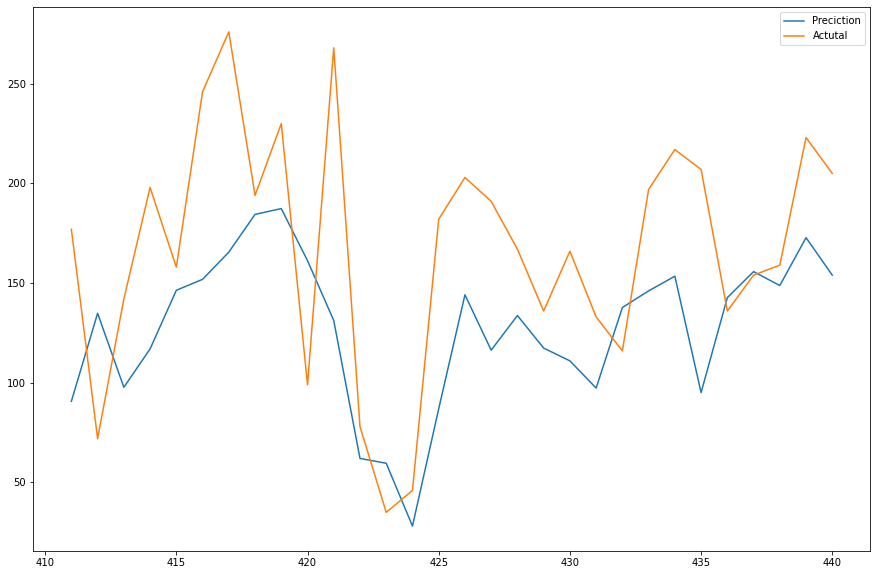

In [307]:
plt.figure(figsize=(15,10))
plt.plot(test.tail(30), label = 'Preciction')
plt.plot(targ.tail(30),label = 'Actutal')
plt.legend()

Предсказания трудно назвать хорошими, но мы укладываемся в ограничения

<a id='Conclusion'></a>
### 5. Выводы

1. Рассмотрели временной ряд заказов такси с марта по август 2018 года  
2. Выявили сезонность в течение дня, и положительный тренд  
3. В конце августа заметили аномальные значения  - очень высокое количество заказов, поскольку это был последний месяц наблюдений, сложно сделать вывод о "аномальности" и возможности заменить на средние значения  
4. Применили модель Линейной регрессии, меняли количество шагов назад, с которыми мы обучали модель. Лучший результат на тестовой выборке показала модель с 30 лагами  
5. Применили модель LightGBM, лучший результат оказался при 450  estimators, num_leaves = 18, max_depth = 25  
Значение RMSE на тестовой выборке составило 43.7 - как и у модели линейной регрессии.  
Судя по графику, наша модель далека от идеала
